# Analyzing Data on Data Scientists
In this notebook I will be trying to gain some insight into the data science job market in Toronto, Ontario. I want to answer questions like:
- What are the primary job duties for a data scientist?
- What are the main skills employers are looking for in a new hire?
- What type of education is most useful for real-life data science projects?

To answer these questions I will be using two datasets that I scraped from the web. One is a collection of data science job postings and the second one is a collection of data scientist user profiles scraped from social media sites.

In [7]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import nltk
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import gensim

In [8]:
#Job postings dataset
jobs_df = pd.read_csv('../data/jobs.csv')
jobs_df.head()

,Unnamed: 0,job_title,company,location,job_summary
0,0,Data Scientist,Indeed Prime,"Toronto, ON",indeed prime is a free service that connects q...
1,1,Data Scientist - Client Success,Equifax,"Toronto, ON",would you like to work in a fully agile enviro...
2,2,Data Scientist,Proex Inc,"North York, ON","data scientist\n(4-month contract)\ntoronto, o..."
3,3,Data Scientist - Engineering,Capital One,"Toronto, ON","161 bay street (93021), canada, toronto,toront..."
4,4,Data Engineer,Sun Life Financial,"Toronto, ON","at sun life, we work together, share common va..."


Lets start with the job postings dataset. Here we have information regarding the job summary or put in other words: information about what employers are looking for in a new hire. The information that I am most interested in is in the job_summary column, so lets take a closer look.

In [9]:
#Take a look at a random job summary
jobs_df.iloc[2].job_summary

'data scientist\n(4-month contract)\ntoronto, on\npharmaceutical manufacturing\n\nyour task:\nwrite algorithms on anomaly detection\nyour background:\nmanufacturing would be the ideal, but finance experience is also of interest (writing algorithms for fraud prevention is a good parallel to the type of anomaly detection that is required for this assignment)\npharma experience would be an asset, but not necessary.\n\n[alten-email email=heather@proex.ca]'

In [10]:
#Clean the text by removing newline characters "\n"
jobs_df.job_summary = jobs_df.job_summary.apply(lambda x: re.sub('\n', ' ', x))
jobs_df.iloc[2].job_summary

'data scientist (4-month contract) toronto, on pharmaceutical manufacturing  your task: write algorithms on anomaly detection your background: manufacturing would be the ideal, but finance experience is also of interest (writing algorithms for fraud prevention is a good parallel to the type of anomaly detection that is required for this assignment) pharma experience would be an asset, but not necessary.  [alten-email email=heather@proex.ca]'

In [16]:
#Store all job_summaries into one string
job_summary = jobs_df.job_summary.str.cat()

# Wordcloud
Let us look at a wordcloud of the job summary to see which words are the most frequent. This may give us an idea of the most in demand skills that employers look for.

## Text Preprocessing: Lemmatization
Lets try to remove some of the repeated information before displaying a word cloud with a technique called Lemmatization. In simple terms, lemmatizing is the process of converting words to its most basic form. For example: "amusement, amusing, and amused" will all be transformed to the word "amuse". Doing this on our dataset will effectively reduce the number of repeated words in our word cloud.

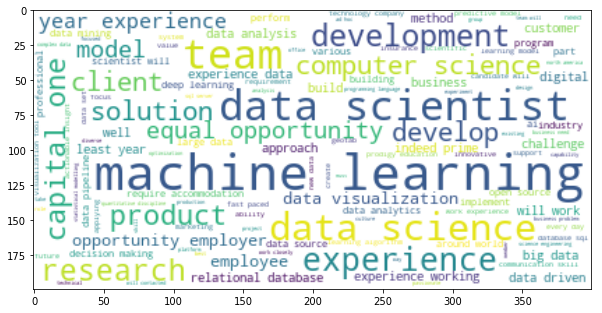

In [17]:
lemma = nltk.WordNetLemmatizer()
words_to_lemma = job_summary.split()
job_summary_lemma = [lemma.lemmatize(word) for word in words_to_lemma]
job_summary_lemma = ' '.join(job_summary_lemma)

wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(job_summary_lemma)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')

Looking at our word cloud, we can see that it contains a lot of fluff words that don't really describe certain skills that employers are looking for, such as: "product", "will work", "build", "develop". These words are just likely a frequenct occurence in our job summary corpus and thus being displayed in the word cloud.

However, the word cloud is still able to tell us some useful information, namely the most looked for skills are:
- Machine Learning
- Data Visualization
- Data Mining
- Relational Database (SQL)
- Big Data
- Computer Science

# Advanced Technique: Word2Vec
Alright so thanks to our word cloud, we were able to get a rough idea of the skills which employers are looking for in a data scientist. However, we can also see that the word cloud contains a lot of useless information, namely the fluff words like: "digital", "development", "product", etc...

We are going to try to look for more skills in the data corpus with a deep-learning NLP model, called Word2Vec. Essentially, Word2Vec transforms string values into a vector array of N-dimensions. Now, each unique string is going to have a unique vector assigned to it, but words with similar meaning will have similar vectors.

The idea behind Word2Vec is that words with similar meaning tend to be used around the same surrounding words. For example, lets say we have a sentence: **"Popcorn is the best snack, I ___ popcorn!"**. What is the most likely word in the blank space? Love? Adore? Enjoy? Basically, all of these words are likely to appear in the blank and thus word2vec will find that these words have similar vectors.

**The Plan:**
We are going to train word vectors for our entire data corpus and then use them to find similar words to the skills that we extracted from the word cloud. In other words, we want to find other words with similar meaning to "Machine Learning", "Data Visualization... that were not present in our word cloud.

In [18]:
#Download nltk packages
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/freemanmak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/freemanmak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
#Split the entire data corpus into lists of sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = tokenizer.tokenize(job_summary.strip())
#Take a look at some of the sentences
sentences[:3]

["indeed prime is a free service that connects qualified job-seekers (that's you) with top companies hiring tech roles.",
 'with one application you can be considered for thousands of tech roles from leading companies on indeed prime.',
 "how indeed prime works we find out what's important to you and match you with your dream job get started – complete a 5-minute application to be considered for roles at hundreds of leading companies get matched – companies apply to you with opportunities that reflect your role, location and salary specifications get career coaching – level up with free 1:1 coaching, our team will make sure you're ready to tackle any interview get your dream job  skills and requirements we look for top tech talent to join the indeed prime platform."]

In [45]:
#Remove special characters from the text
sentences = [re.sub("[^a-zA-Z']"," ", s) for s in sentences]

#Convert each sentence into a list of words, so the entire sentence returns a list of lists
sentences = [s.split() for s in sentences]

#Remove stop words from the text
sentences_cleaned = []
stopwords = set(nltk.corpus.stopwords.words('english'))
for sentence in sentences:
    w = [w for w in sentence if w not in stopwords]
    sentences_cleaned.append(w)

In [51]:
#Train our word2vec model
model = gensim.models.word2vec.Word2Vec(sentences_cleaned, workers=4, 
                          size=300, min_count = 20, 
                          window = 10, sample = 1e-3)



Now that we have trained our word2vec model, we can take a look at similar words by comparing the word vectors together. So lets take a look at the most similar words to the skills that we found using our word cloud.

In [61]:
model.wv.most_similar("machine")

[('modelling', 0.9987617135047913),
 ('learning', 0.9986103177070618),
 ('data', 0.9981669783592224),
 ('statistical', 0.9980508089065552),
 ('r', 0.9978537559509277),
 ('sas', 0.9977183938026428),
 ('sql', 0.9976361989974976),
 ('programming', 0.9972052574157715),
 ('analysis', 0.9971882104873657),
 ('knowledge', 0.9970457553863525)]

In [62]:
model.wv.most_similar("learning")

[('modelling', 0.9996521472930908),
 ('statistical', 0.9993504881858826),
 ('knowledge', 0.9993401765823364),
 ('modeling', 0.9993306398391724),
 ('analysis', 0.9992907047271729),
 ('understanding', 0.9989206790924072),
 ('algorithms', 0.9989192485809326),
 ('techniques', 0.9988762140274048),
 ('predictive', 0.9988335371017456),
 ('models', 0.9987353682518005)]

There is a slight problem with our implementation of word2vec model so far, can you guess what it is? We were able to find the most similar words to "machine" and "learning" seperately, we were unable to find the the most similar words to "machine learning". When you add these two words together, the meaning changes drastically and with our current implementation, this is not being shown.

Seeing as how most of the skills we extracted from our word cloud are a combination of two words (also called a bigram). We need a method to include these combinations of words into our training data for word2vec to see. Currently, the model is taking a list of lists as words in which each individual list contains seperate words which form a sentence. We are going to alter this list so that it also contains bigrams as well. 

Here is an example of what we wish to do:
- **input:** **A data scientist uses machine learning on big data."**
- **output:** **[A, data_scientist, uses, machine_learning, on big_data]**

In [74]:
#Use the gensim phrases package to get bigrams
bigrams = gensim.models.phrases.Phrases(sentences)
print(bigrams["A data scientist uses machine learning on big data".split()])

['A', 'data_scientist', 'uses', 'machine_learning', 'on', 'big_data']


In [77]:
model = gensim.models.word2vec.Word2Vec(bigrams[sentences_cleaned], workers=4, 
                          size=300, min_count = 20, 
                          window = 10, sample = 1e-3)

In [78]:
model.wv.most_similar("machine_learning")

[('analysis', 0.999938428401947),
 ('python', 0.9999266862869263),
 ('programming', 0.9999236464500427),
 ('testing', 0.9999234676361084),
 ('big_data', 0.9999186396598816),
 ('statistical', 0.9999183416366577),
 ('using', 0.9999165534973145),
 ('models', 0.9999160766601562),
 ('knowledge', 0.9999155402183533),
 ('large', 0.9999154806137085)]

In [86]:
model.wv.most_similar("data_visualization")

[('skills', 0.9999260902404785),
 ('management', 0.9999204277992249),
 ('knowledge', 0.9999169111251831),
 ('advanced', 0.999916672706604),
 ('strong', 0.9999139308929443),
 ('understanding', 0.9999136328697205),
 ('industry', 0.9999110102653503),
 ('large', 0.9999099969863892),
 ('responsibilities', 0.9999095797538757),
 ('etc', 0.9999072551727295)]

In [87]:
model.wv.most_similar("data_mining")

[('techniques', 0.9999349117279053),
 ('statistical', 0.9999333620071411),
 ('understanding', 0.9999277591705322),
 ('processing', 0.9999246597290039),
 ('strong', 0.9999240040779114),
 ('using', 0.9999226331710815),
 ('systems', 0.9999225735664368),
 ('knowledge', 0.9999223947525024),
 ('analysis', 0.9999176263809204),
 ('algorithms', 0.9999161958694458)]

In [88]:
model.wv.most_similar("relational_database")

[('extract', 0.9998733401298523),
 ('manipulate_raw', 0.9998618960380554),
 ('full', 0.9998569488525391),
 ('sql_server', 0.9998562932014465),
 ('large', 0.9998488426208496),
 ('big_data', 0.9998340010643005),
 ('models', 0.9998315572738647),
 ('queries', 0.9998314380645752),
 ('various', 0.9998303055763245),
 ('using', 0.9998286962509155)]

In [89]:
model.wv.most_similar("computer_science")

[('degree', 0.9999321103096008),
 ('related', 0.999930739402771),
 ('engineering', 0.9999141693115234),
 ('statistics', 0.9999096989631653),
 ('master', 0.9999010562896729),
 ('machine_learning', 0.9998946785926819),
 ('requirements', 0.9998908042907715),
 ('programming', 0.9998871088027954),
 ('analysis', 0.9998869895935059),
 ('education', 0.9998868107795715)]

In [93]:
model.wv.most_similar("big_data")

[('knowledge', 0.9999340176582336),
 ('statistical', 0.9999338388442993),
 ('testing', 0.9999327659606934),
 ('using', 0.9999305605888367),
 ('processing', 0.999929666519165),
 ('etc', 0.9999278783798218),
 ('tools', 0.9999276399612427),
 ('strong', 0.9999262094497681),
 ('skills', 0.9999257326126099),
 ('large', 0.9999256134033203)]